In [1]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [03:30<00:00, 37.0MB/s]
100% 6.31G/6.31G [03:30<00:00, 32.2MB/s]


In [6]:
!unzip /content/histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [12]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Load data
df = pd.read_csv("/content/train_labels.csv")

# Prepare file paths
df["path"] = df["id"].apply(lambda x: os.path.join("/content/train", str(x) + ".tif"))

# Subset data
df["label"] = df["label"].astype(str)
df_0 = df[df["label"] == "0"].sample(10000, random_state=42)
df_1 = df[df["label"] == "1"].sample(10000, random_state=42)
df_subset = pd.concat([df_0, df_1], ignore_index=True)

# Split data into train and test
train_df, test_df = train_test_split(df_subset, test_size=0.2, random_state=42)

# Define ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for train and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Since paths are already absolute
    x_col="path",
    y_col="label",
    target_size=(96,96),  # Set the image dimensions
    batch_size=128,
    class_mode="binary",  # Assuming binary classification
    shuffle=True,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="path",
    y_col="label",
    target_size=(96, 96),
    batch_size=128,
    class_mode="binary",
    shuffle=False,  # No need to shuffle test data
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Build CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 128,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 128
)

Epoch 1/20
125/125 [==============================] - 64s 436ms/step - loss: 0.5579 - accuracy: 0.7036 - val_loss: 0.4861 - val_accuracy: 0.7790
Epoch 2/20
125/125 [==============================] - 62s 496ms/step - loss: 0.4812 - accuracy: 0.7742 - val_loss: 0.4681 - val_accuracy: 0.7853
Epoch 3/20
125/125 [==============================] - 57s 460ms/step - loss: 0.4775 - accuracy: 0.7787 - val_loss: 0.4576 - val_accuracy: 0.7966
Epoch 4/20
125/125 [==============================] - 46s 370ms/step - loss: 0.4624 - accuracy: 0.7874 - val_loss: 0.4393 - val_accuracy: 0.7941
Epoch 5/20
125/125 [==============================] - 45s 361ms/step - loss: 0.4540 - accuracy: 0.7929 - val_loss: 0.4301 - val_accuracy: 0.8080
Epoch 6/20
125/125 [==============================] - 48s 388ms/step - loss: 0.4348 - accuracy: 0.8024 - val_loss: 0.4586 - val_accuracy: 0.7926
Epoch 7/20
125/125 [==============================] - 46s 368ms/step - loss: 0.4212 - accuracy: 0.8079 - val_loss: 0.4227 - val_ac

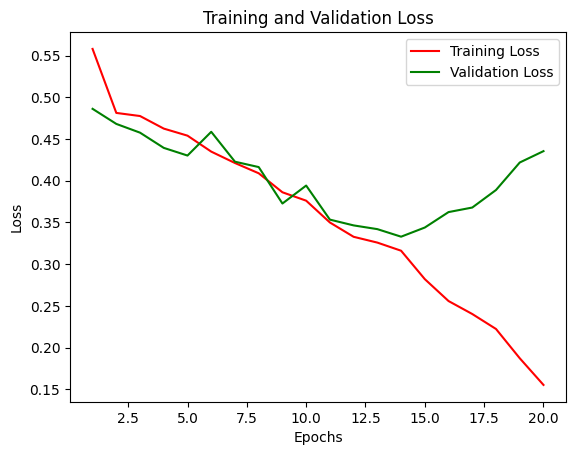

In [20]:
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

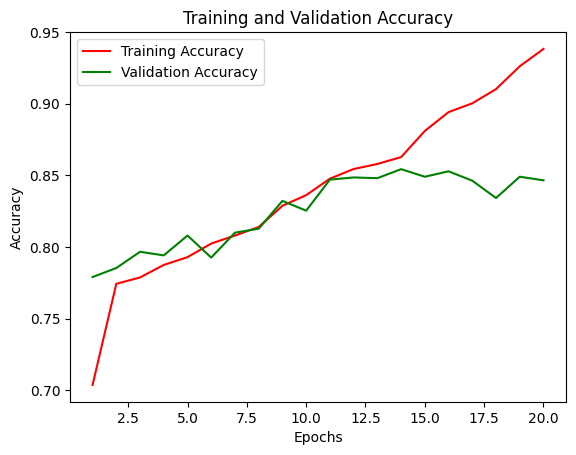

In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(test_generator)
print(test_loss)
print(test_acc*100)

32/32 [==============================] - 12s 355ms/step - loss: 0.4356 - accuracy: 0.8462
0.43564003705978394
84.62499976158142


32/32 [==============================] - 6s 178ms/step


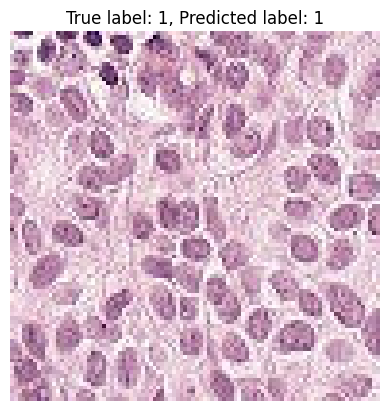

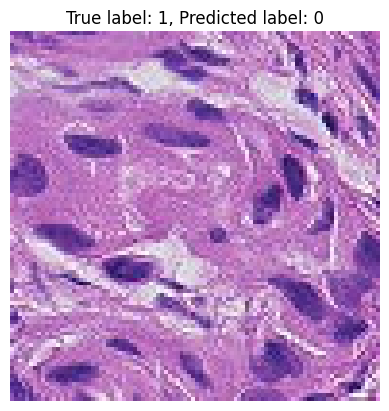

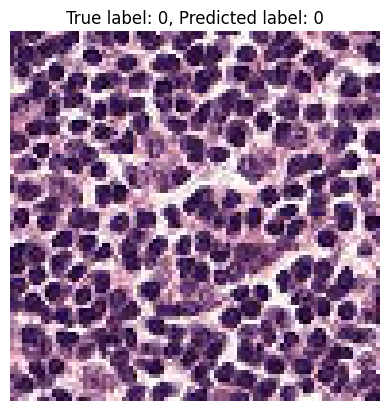

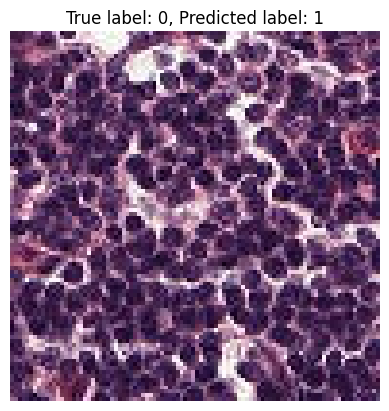

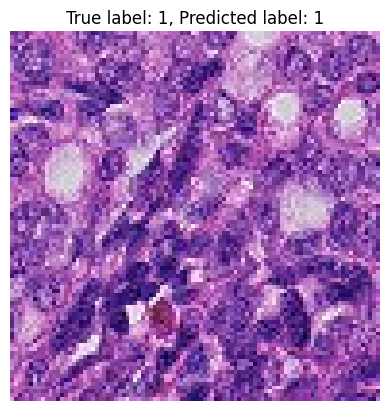

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for the test data
test_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(test_generator)

# Get true labels
true_labels = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Display images with true and predicted labels
num_images_to_display = 5
for i in range(num_images_to_display):
    image, true_label = test_generator[i]
    true_label_scalar = true_label[0]  # Extract scalar value from the array
    predicted_label = predictions[i]
    predicted_class = 1 if predicted_label > 0.5 else 0  # Convert predicted probability to class label

    plt.imshow(image[0])
    plt.axis('off')
    plt.title(f"True label: {class_labels[int(true_label_scalar)]}, Predicted label: {class_labels[predicted_class]}")
    plt.show()